# Predator-prey model tutorial

This is a simple tutorial to introduce you to the continuation of periodic orbits using the famous predator-prey model, a.k.a. the Lotka-Volterra equations:

$\dot{x} = a\ x - b\ xy$<br />
$\dot{y} = d\ xy - c\ y$

With the parameters $a$, $b$, $c$, and $d$.

First, let's import the packages that we will need:

In [65]:
from IPython.display import display
import sys  # noqa

sys.path.append("../..")  # noqa
from bice import Problem, Equation, time_steppers, MyNewtonSolver
from bice.continuation import TimePeriodicOrbitHandler, NaturalContinuation
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Now, we can define the Lotka-Volterra equations as a class:

In [66]:
# The Lotka-Volterra equations (predator prey model)
class LotkaVolterraEquations(Equation):
    def __init__(self):
        super().__init__()
        # parameters
        self.a = 1
        self.b = 1
        self.c = 1
        self.d = 1
        # initial condition
        self.u = np.array([1.0, 0.7])

    def rhs(self, u):
        x, y = u
        return np.array([(self.a - self.b * y) * x, (self.d * x - self.c) * y])

Next, we set up the problem and add the equations to it.

In [67]:
# create a problem
problem = Problem()
# create instance of the equation and add it to the problem
lve = LotkaVolterraEquations()
problem.add_equation(lve)

Let's start with some time stepping:

# steps: 5000


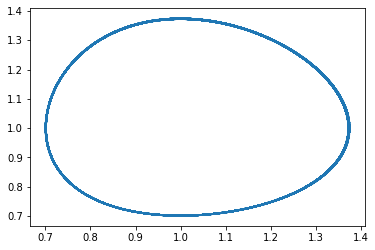

In [68]:
# Feel free to experiment with different time stepping schemes
# problem.time_stepper = time_steppers.BDF(problem)
# problem.time_stepper = time_steppers.BDF2(dt=1e-1)
# problem.time_stepper = time_steppers.Euler(dt=5e-4)
# problem.time_stepper = time_steppers.ImplicitEuler(dt=1e-2)
problem.time_stepper = time_steppers.RungeKutta4(dt=2e-1)

# do the time-stepping
data = []
while problem.time < 1e3:
    data.append(problem.u.copy())
    problem.time_step()
print("# steps:", len(data))

# visualize the trajectory in phase space
data = np.array(data)
plt.plot(data[:, 0], data[:, 1], label="time-stepping solution")

We now want to perform a parameter continuation of the periodic orbit. Therefor, we need to create a new type of equation, that does not only describe the dynamics of a single point in time, but that holds the full orbit.

While the original Lotka-Volterra equations form a set of ordinary differential equations, we now consider them as partial differential equation on a one-dimensional periodic temporal domain $t \in [0, T]$ with the period length $T$.

The `TimePeriodicOrbitHandler` is an Equation type class coming with bice that does exactly this: it transforms some equation (ODE, PDE, ...) to a higher dimensional equation on some temporal domain $[0, T]$. Additionally, it transforms the time to $\tilde t = t/T$, such that the static domain $\tilde t \in [0, 1]$ can be considered while the period length $T$ can serve as an additional variable of the equation. This allows us to solve for an unkown orbit of unkown period length!

Due to the continuous symmetry (temporal invariance) of periodic orbits, the `TimePeriodicOrbitHandler` introduces an additional phase constraint into the system, namely $\int_0^T \dot{u}\cdot u \ \mathrm{d} t = 0$, which breaks the symmetry and thus assures that the solution is unique.

Now, let's create the orbit handler and replace the problem's equation with it!

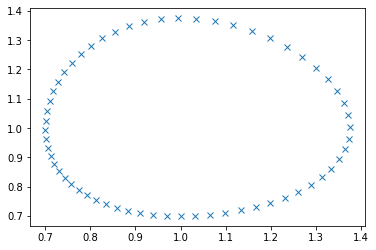

In [69]:
# initial guess for period length
T = 6.34
# number of discrete time steps in orbit
Nt = 60
# create orbit handler for the Lotka-Volterra equations
orbitHandler = TimePeriodicOrbitHandler(lve, T, Nt)

# set the initial condition for the orbit handler
u_orbit = []
problem.time_stepper.dt = T / Nt
for i in range(Nt):
    u_orbit.append(lve.u.copy())
    problem.time_step()
orbitHandler.u = np.append(u_orbit, T)

# replace the Problem's equation with the orbit handler
problem.remove_equation(lve)
problem.add_equation(orbitHandler)

# visualize the initial condition
x, y = orbitHandler.u_orbit().T
plt.plot(y, x, "x")

We proceed with performing a simple (natural) continuation of the time periodic orbit.

First, let us set the Newton solver and continuation settings:

In [70]:
# Use simple MyNewtonSolver, because it is faster for small problems
problem.newton_solver = MyNewtonSolver()

# set up the natural continuation stepper
problem.continuation_stepper = NaturalContinuation()
problem.continuation_stepper.ds = 0.05
problem.continuation_parameter = (lve, "b")
problem.neigs = 0  # no eigenvalue calculation

We are now ready to run the continuation. In addition to the continuation steps, we calculate the Floquet multipliers to obtain the stability. If some multiplier is larger then one, the solution would be unstable. 

Step #1, T = 6.34e+00, param = 1.05e+00
Floquet multipliers: [0.16947455+0.01585267j 0.16947455-0.01585267j] (stable)
Step #2, T = 6.34e+00, param = 1.10e+00
Floquet multipliers: [0.1694749+0.01585297j 0.1694749-0.01585297j] (stable)
Step #3, T = 6.34e+00, param = 1.15e+00
Floquet multipliers: [0.16947455+0.01585283j 0.16947455-0.01585283j] (stable)
Step #4, T = 6.34e+00, param = 1.20e+00
Floquet multipliers: [0.16947476+0.01585266j 0.16947476-0.01585266j] (stable)
Step #5, T = 6.34e+00, param = 1.25e+00
Floquet multipliers: [0.16947457+0.01585281j 0.16947457-0.01585281j] (stable)
Step #6, T = 6.34e+00, param = 1.30e+00
Floquet multipliers: [0.16947455+0.01585269j 0.16947455-0.01585269j] (stable)
Step #7, T = 6.34e+00, param = 1.35e+00
Floquet multipliers: [0.16947464+0.01585292j 0.16947464-0.01585292j] (stable)
Step #8, T = 6.34e+00, param = 1.40e+00
Floquet multipliers: [0.16947474+0.015853j 0.16947474-0.015853j] (stable)
Step #9, T = 6.34e+00, param = 1.45e+00
Floquet multipliers: [

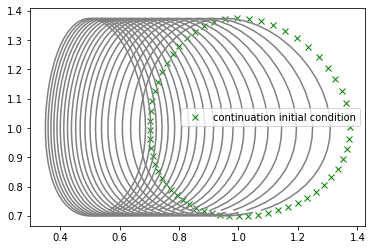

In [71]:
# again, visualize the initial condition
x, y = orbitHandler.u_orbit().T
plt.plot(y, x, "x", color="green", label="continuation initial condition")

# perform continuation steps
n = 0
while n < 20:
    problem.continuation_step()
    n += 1
    # plot
    x, y = orbitHandler.u_orbit().T
    plt.plot(y, x, color="grey")
    p = problem.get_continuation_parameter()
    print(f"Step #{n}, T = {orbitHandler.T:.2e}, param = {p:.2e}")

    # calculate stability of orbits
    floquet_mul = orbitHandler.floquet_multipliers()
    tol = 1e-5
    stable = "(unstable)" if np.any([abs(mul) > 1 + tol for mul in floquet_mul]) else "(stable)"
    print("Floquet multipliers:", floquet_mul, stable)

plt.legend()
plt.show()

Voila! There is a nice set of periodic orbits for varying values of the continuation parameter!